<a href="https://colab.research.google.com/github/joaochenriques/HydroFit/blob/main/Fit_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import matplotlib.pyplot as mpl
import numpy as np
from scipy.optimize import curve_fit

import pathlib, subprocess, os
import pandas as pd

def cmdcall( cmd, verbose=True ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

In [12]:
if not pathlib.Path("mpl_utils.py").exists():
    cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

from IPython.display import display, clear_output

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3921  100  3921    0     0  13829      0 --:--:-- --:--:-- --:--:-- 13855


In [37]:
x = np.array( [855, 1105, 1524, 2287, 3258, 5944,8719, 14759 ] )
y = np.array( [ 27775378.25, 27657739, 27317603, 26845590.5, 26633231, 26198128.75, 26033780.25, 25885391 ] )
u = y / np.min( y )
h = 1.0 / x
h, u

(array([1.16959064e-03, 9.04977376e-04, 6.56167979e-04, 4.37254045e-04,
        3.06936771e-04, 1.68236878e-04, 1.14692052e-04, 6.77552680e-05]),
 array([1.07301366, 1.06846904, 1.05532897, 1.03709426, 1.02889043,
        1.01208163, 1.00573255, 1.        ]))

In [66]:
def func(x, a, b, c):
    return a + b * x**c

popt, pcov = curve_fit(func, h[4:], u[4:] )#, p0 = [2.56, 1, 2.0] )
popt

array([  0.99191392, 124.60915314,   1.00419962])

25676079.66420622

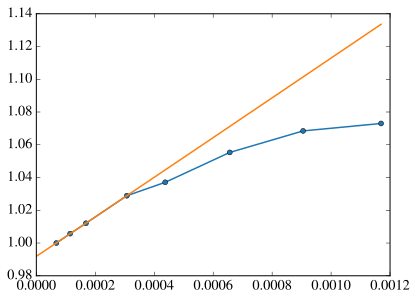

In [67]:
h0 = np.linspace( 0.0, np.max(h), 500 )
y0 = func( h0, *popt )
y0

mpl.plot( h, u, 'o-' );
mpl.plot( h0, y0, '-' );
popt[0]*np.min( y )